In [2]:
import numpy as np
import scanpy as sc
import numpy as np
import pandas as pd

import anndata2ri
import logging
from scipy.sparse import issparse
from CSCORE.CSCORE_IRLS import CSCORE_IRLS

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

In [3]:
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/scratch/3285911.1.academic-gpu/ipykernel_1082518/1068135002.py:3: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
%%R 
library(Seurat)
library(sctransform)
library(Hmisc)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
[1] "value"


In [13]:
adata = sc.read_h5ad('/projectnb/cs598/projects/singleCell/data/Global_raw.h5ad')

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)
hvg_list = adata.var[adata.var['highly_variable']].index.tolist()

adata = adata[:, hvg_list]

In [14]:
adata.shape

(704296, 3000)

(5000, 3000)


/scratch/3285911.1.academic-gpu/ipykernel_1082518/403552071.py:13: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


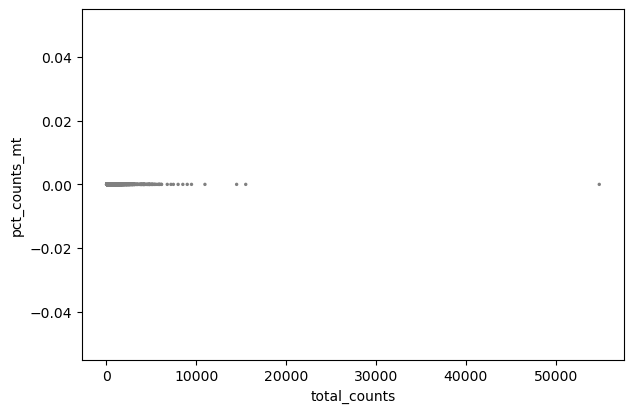

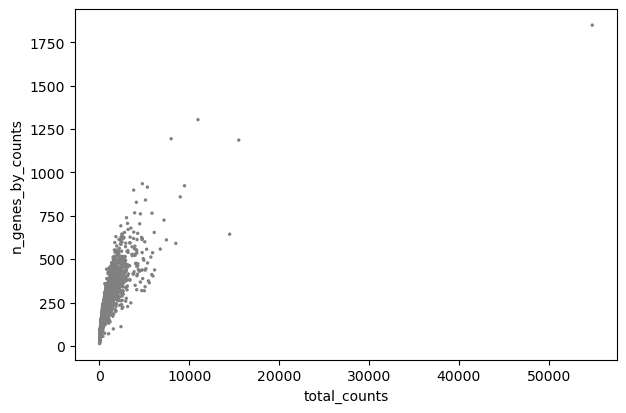

/scratch/3285911.1.academic-gpu/ipykernel_1082518/403552071.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = np.array(np.sum(adata.X, axis= 1))


In [15]:
#for i in glob.glob("./spleen/scrna_*.h5ad"):
#    print(i)

#read_path = f"./{tissue_id}/scrna_{tissue_id}_{identify}.h5ad"

# Select 5,000 random cells
random_cell_indices = np.random.choice(adata.n_obs, 5000, replace=False)
adata = adata[random_cell_indices, :]

# Verify the shape
print(adata.shape)  

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

adata = adata[:,adata.var['mt']==False]

if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()
ro.globalenv["adata"] = adata

adata.obs['n_counts'] = np.array(np.sum(adata.X, axis= 1))

In [16]:
%%R
seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")
res = SCTransform(object=seurat_obj, vst.flavor = "v2", variable.features.n = 1000 , method = "glmGamPoi", verbose = FALSE)

[1] "value"


In [ ]:
print(adata.obs)

In [17]:
gene_list = list(ro.r("rownames(res@assays$SCT@scale.data)"))
norm_x = ro.r("res@assays$SCT@scale.data")
exp_matrix = pd.DataFrame(norm_x, index=gene_list)
adata_new = adata[:,gene_list]

print(adata_new.shape)
counts = adata_new.X
print("Shape of counts:", counts.shape)
seq_depth = adata_new.obs['n_counts'].values
print(adata_new.X.shape)
print(type(counts))
print("Shape of seq_depth:", seq_depth.shape) 
counts = counts.toarray()
B_cell_result = CSCORE_IRLS(np.array(counts), seq_depth)
p_value = B_cell_result[1]
cor_matrix = (p_value<0.005)*1
print(cor_matrix)

(5000, 1000)
Shape of counts: (5000, 1000)
(5000, 1000)
<class 'anndata._core.views.SparseCSRMatrixView'>
Shape of seq_depth: (5000,)
IRLS converged after 5 iterations.
0.0050% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.
[[1 1 1 ... 1 1 1]
 [1 1 0 ... 0 1 0]
 [1 0 1 ... 1 1 1]
 ...
 [1 0 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]]


In [18]:
exp_matrix.to_csv("/projectnb/cs598/projects/singleCell/data/heart_rna_expression.csv")
cor_matrix = pd.DataFrame(cor_matrix, index = gene_list, columns = gene_list)
cor_matrix.to_csv("/projectnb/cs598/projects/singleCell/data/heart_rna_pvalue.csv")